# Plots for mutation growth rate paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update                       # Downloads data (~1hour).
make preprocess                   # Preprocesses data (~3days on a big machine).
python mutrans.py --vary-holdout  # Fits and crossvalidates model (~1hour GPU).
```

In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.ops.tensor_utils import convolve
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import (
    pretty_print, pearson_correlation, quotient_central_moments, generate_colors
)
from pyrocov.sarscov2 import GENE_TO_POSITION, GENE_STRUCTURE, aa_mutation_to_position

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.01
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']
matplotlib.rcParams.update({
    # 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

## Load data

In [2]:
max_num_clades = 3000
min_num_mutations = 1

In [3]:
%%time
def load_data():
    filename = f"results/mutrans.data.single.{max_num_clades}.{min_num_mutations}.50.None.pt"
    dataset = torch.load(filename, map_location="cpu")
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset
dataset = load_data()
locals().update(dataset)
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

    37457 Loaded 909 x 3627 daily case data, totaling 653322752.0
    37458 Joining GISAID and JHU region codes
    37576 Matching 1900 GISAID regions to 3627 JHU fuzzy regions


clade_id 	dict of size 3000
clade_id_inv 	list of size 3000
clade_id_to_lineage_id 	Tensor of shape (3000,)
clade_to_lineage 	dict of size 3000
daily_cases 	Tensor of shape (909, 1900)
features 	Tensor of shape (3000, 2984)
lineage_id 	dict of size 1862
lineage_id_inv 	list of size 1862
lineage_id_to_clade_id 	Tensor of shape (1862,)
lineage_to_clade 	dict of size 1862
location_id 	OrderedDict of size 1900
location_id_inv 	list of size 1900
mutations 	list of size 2984
pc_index 	Tensor of shape (254067,)
sparse_counts 	dict of size 3
state_to_country 	Tensor of shape (1685,)
time 	Tensor of shape (70,)
weekly_cases 	Tensor of shape (70, 1900)
weekly_clades 	Tensor of shape (70, 1900, 3000)
CPU times: user 794 ms, sys: 570 ms, total: 1.36 s
Wall time: 1.14 s


Create a dense mapping between fine clades and Pango lineages.

In [4]:
print("{} x {} x {} = {}".format(*weekly_clades.shape, weekly_clades.shape.numel()))
print(int(weekly_clades.sum()))
print(weekly_clades.ne(0).float().mean().item())
print(weekly_clades.ne(0).any(0).float().mean().item())

70 x 1900 x 3000 = 399000000
10395987
0.002167674247175455
0.04457315802574158


In [5]:
with open(f"results/columns.{max_num_clades}.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 10395987 samples


In [6]:
try:
    with open("results/nextclade.counts.pkl", "rb") as f:
        all_mutations = pickle.load(f)
except Exception:
    with open("results/stats.pkl", "rb") as f:
        all_mutations = pickle.load(f)["aaSubstitutions"]
print(f"Loaded {len(all_mutations)} mutations")

Loaded 71504 mutations


Sanity checking case count time series:

In [7]:
if False:
    plt.figure(figsize=(8, 3))
    plt.plot(weekly_cases, lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("confirmed cases");

    plt.figure(figsize=(8, 3))
    plt.plot(weekly_clades.sum(-1), lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("sequenced samples");

In [8]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

53 4 1843


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [9]:
fits = torch.load("results/mutrans.pt", map_location="cpu")

In [10]:
for key in fits:
    print(key)

('coef_scale=0.05', 'reparam-localinit', 'full', 10001, 0.05, 0.1, 10.0, 200, 6, None, ())


In [11]:
best_fit = list(fits.values())[0]
pretty_print(best_fit, max_items=40)

: dict of length 19
['median']: dict of length 13
['median']['coef_scale']: Tensor of shape ()
['median']['rate_scale']: Tensor of shape ()
['median']['init_scale']: Tensor of shape ()
['median']['rate_loc_scale']: Tensor of shape ()
['median']['init_loc_scale']: Tensor of shape ()
['median']['coef_decentered']: Tensor of shape (2984,)
['median']['coef']: Tensor of shape (2984,)
['median']['rate_loc']: Tensor of shape (3000,)
['median']['init_loc_decentered']: Tensor of shape (3000,)
['median']['init_loc']: Tensor of shape (3000,)
['median']['rate']: Tensor of shape (1900, 3000)
['median']['init']: Tensor of shape (1900, 3000)
['median']['probs']: Tensor of shape (76, 1900, 1862)
['mean']: dict of length 13
['mean']['coef_scale']: Tensor of shape ()
['mean']['init_loc']: Tensor of shape (3000,)
['mean']['rate_loc']: Tensor of shape (3000,)
['mean']['rate_scale']: Tensor of shape ()
['mean']['init_loc_decentered']: Tensor of shape (3000,)
['mean']['coef_decentered']: Tensor of shape (29

Scale `coef` by 1/100 in all results.

In [12]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('coef_scale=0.05', 'reparam-localinit', 'full', 10001, 0.05, 0.1, 10.0, 200, 6, None, ()).median.coef
.('coef_scale=0.05', 'reparam-localinit', 'full', 10001, 0.05, 0.1, 10.0, 200, 6, None, ()).mean.coef
.('coef_scale=0.05', 'reparam-localinit', 'full', 10001, 0.05, 0.1, 10.0, 200, 6, None, ()).std.coef


In [13]:
print(list(best_fit["params"]))

['coef_centered', 'init_loc_centered', 'pc_rate_centered', 'pc_init_centered', 'AutoLowRankMultivariateNormal.loc', 'AutoLowRankMultivariateNormal.scale']


In [14]:
if False:
    plt.plot(
        best_fit["mean"]["init_loc"] + 0 * best_fit["median"]["init"],
        best_fit["median"]["init"],
        "k.",
    )


## Assess model fitness

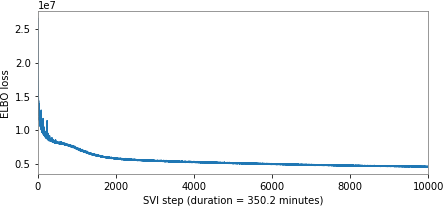

In [15]:
def plot_loss(key, fit, filenames=()):
    num_nonzero = int(torch.count_nonzero(weekly_clades))
    median = fit.get("median", fit.get("mean", {}))
    plt.figure(figsize=(7, 3))
    time = np.arange(1, 1 + len(fit["losses"]))
    plt.plot(fit["losses"], label="ELBO loss")
    plt.xlim(0, len(fit["losses"]) - 1)
    plt.ylabel("ELBO loss")
    plt.xlabel("SVI step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
    for filename in filenames:
        plt.savefig(filename)

plot_loss(*list(fits.items())[0], filenames=["paper/convergence_loss.png"])

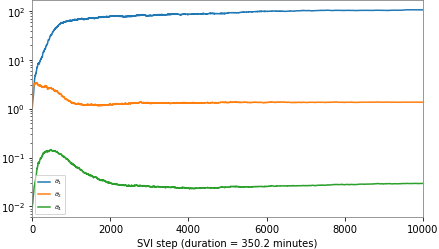

In [16]:
def plot_scalars(key, fit, filenames=()):
    num_nonzero = int(torch.count_nonzero(weekly_clades))
    median = fit.get("median", fit.get("mean", {}))
    plt.figure(figsize=(7, 4))
    time = np.arange(1, 1 + len(fit["losses"]))
    aliases = {
        "init_loc_scale": r"$\widehat\sigma_1$",
        "init_scale": r"$\widehat\sigma_2$",
        "coef_scale": r"$\widehat\sigma_3$",
        "rate_scale": r"$\widehat\sigma_4$",
    }
    locs = []
    for name, series in fit["series"].items():
        rankby = -torch.tensor(series).log1p().mean().item()
        name = aliases.get(name)
        if name is not None:
            locs.append((name, series, rankby))
    locs.sort(key=lambda x: x[-1])
    for name, series, _ in locs:
        plt.plot(time, series, label=name)
    for name, series, _ in locs:
        plt.plot(time, series, color="white", lw=3, alpha=0.3, zorder=-1)
    plt.yscale("log")
    plt.legend(loc="best", fontsize=6)
    plt.xlabel("SVI step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
    plt.xlim(0, len(fit["losses"]))

plot_scalars(*list(fits.items())[0], filenames=["paper/convergence.png"])

## Interpreting results

In [17]:
best_fit.keys()

dict_keys(['median', 'mean', 'std', 'ELL', 'losses', 'series', 'params', 'walltime', 'args', 'mutations', 'weekly_clades', 'weekly_cases', 'weekly_clades_shape', 'location_id', 'clade_id_inv', 'clade_to_lineage', 'lineage_to_clade', 'location_id_inv', 'lineage_id_inv'])

In [18]:
best_fit["mean"]["rate"].shape

torch.Size([1900, 3000])

In [19]:
def plusminus(mean, std):
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

def generate_rainbow(fit, lineage_names):
    rate = fit["mean"]["rate"].mean(0)
    rates = torch.stack([
        rate[clade_id[lineage_to_clade[l]]] for l in lineage_names
    ])
    C = len(lineage_names)
    colors = [None] * C
    for c, l in enumerate(rates.sort(0).indices.tolist()):
        colors[l] = cm.rainbow(c / (C - 1))
    return colors

def plot_forecast(
    fit,
    queries=None,
    num_strains=10,
    strains=None,
    plot_bg=False,
    filenames=[],
):
    if queries is None:
        queries = list(location_id)
    elif isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 0.5 + 2.5 * len(queries)), sharex=True)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    dates = matplotlib.dates.date2num(mutrans.date_range(len(fit["mean"]["probs"])))
    forecast_steps = len(fit["mean"]["probs"]) - len(weekly_cases)
    assert forecast_steps >= 0
    probs = plusminus(fit["mean"]["probs"], fit["std"]["probs"])  # [3, T, P, L]
    padding = 1 + (weekly_cases.mean(0, True) + weekly_cases[-1]) / 2
    padding = padding.expand(forecast_steps, -1)
    weekly_cases_ = torch.cat([weekly_cases, padding], 0)
    weekly_cases_.add_(1)  # avoid divide by zero
    predicted = probs * weekly_cases_[..., None]
    L = probs.shape[-1]
    weekly_lineages = weekly_clades.new_zeros(weekly_clades.shape[:-1] + (L,)).scatter_add_(
        -1, clade_id_to_lineage_id.expand_as(weekly_clades), weekly_clades
    )
    ids = torch.tensor([i for i, name in enumerate(location_id_inv)
                        if any(q in name for q in queries)])
    rankby = weekly_lineages[:, ids].sum(1)
    rankby = rankby.mean(0) + rankby[-1]
    strain_ids = rankby.sort(-1, descending=True).indices
    strain_ids = strain_ids[:num_strains]
    lineage_names = list(lineage_id_inv[x] for x in strain_ids)
    colors = generate_rainbow(fit, lineage_names)
    assert len(colors) >= num_strains
    light = "#bbbbbb"
    for row, (query, ax) in enumerate(zip(queries, axes)):
        ids = torch.tensor([i for i, name in enumerate(location_id_inv) if query in name])
        print(f"{query} matched {len(ids)} regions")
        if plot_bg:
            counts = weekly_cases[:, ids].sum(1)
            print(f"{query}: max {counts.max():g}, total {counts.sum():g}")
            counts /= counts.max()
            ax.plot(dates[:len(counts)], counts, linestyle="-", color=light, lw=0.8, zorder=-20)
            counts = weekly_lineages[:, ids].sum([1, 2])
            counts /= counts.max()
            ax.plot(dates[:len(counts)], counts, linestyle="--", color=light, lw=1, zorder=-20)
        pred = predicted.index_select(-2, ids).sum(-2)
        pred /= pred[1].sum(-1, True).clamp_(min=1e-20)
        obs = weekly_lineages[:, ids].sum(1)
        obs /= obs.sum(-1, True).clamp_(min=1e-9)
        for s, color in zip(strain_ids, colors):
            lb, mean, ub = pred[..., s]
            ax.fill_between(dates, lb, ub, color=color, alpha=0.2, zorder=-10)
            ax.plot(dates, mean, color=color, lw=1, zorder=-9)
            lineage = lineage_id_inv[s]
            ax.plot(dates[:len(obs)], obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label=lineage if row == 0 else None)
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        #ax.set_ylabel(query.replace(" / ", "\n"))
        ax.set_ylabel(query)
        ax.set_xlim(dates.min(), dates.max())
        if row == 0:
            ax.legend(loc="upper left", fontsize=8 * (10 / num_strains) ** 0.8)
        elif row == 1 and plot_bg:
            ax.plot([], linestyle="--", color=light, lw=1, label="relative #samples")
            ax.plot([], linestyle="-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.fill_between([], [], [], color='gray', label="predicted portion")
            ax.legend(loc="upper left",)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0)
    for filename in filenames:
        plt.savefig(filename)

England matched 1 regions
USA / Mass matched 1 regions
Brazil matched 29 regions


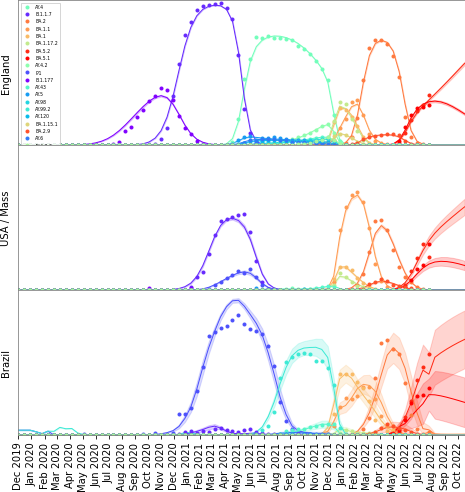

In [20]:
plot_forecast(best_fit,
              queries=["England", "USA / Mass", "Brazil"],
              # queries=["England", "USA / Ca", "Brazil"],
              num_strains=20,
              filenames=["paper/forecast.png"])

England matched 1 regions


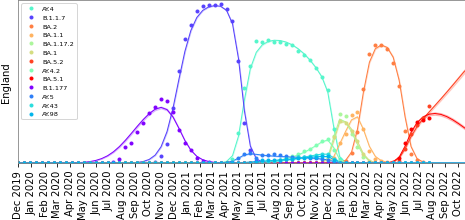

In [21]:
plot_forecast(best_fit, queries=["England"], num_strains=13)

USA / Mass matched 1 regions


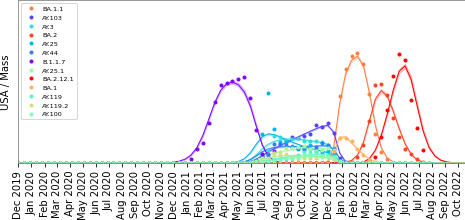

In [22]:
plot_forecast(best_fit, queries=["USA / Mass"], num_strains=13)

South Africa matched 11 regions


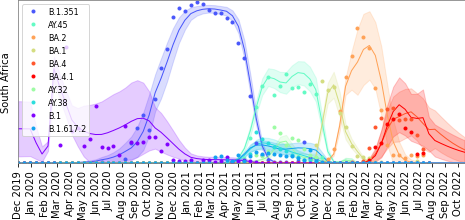

In [23]:
plot_forecast(best_fit, queries=["South Africa"], num_strains=10)

Brazil matched 29 regions


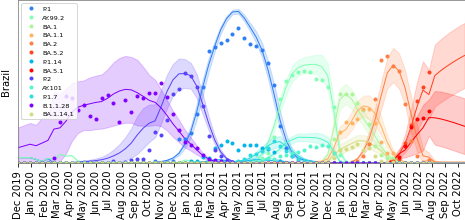

In [24]:
plot_forecast(best_fit, queries=["Brazil"], num_strains=13)

In [ ]:
def plot_prevalence(fit, filenames=()):
    rate = fit["mean"]["rate"].mean(0)
    rate = quotient_central_moments(rate, clade_id_to_lineage_id)[1]
    rate = rate - rate[lineage_id["A"]]
    R = rate.exp()
    probs = fit["mean"]["probs"].mean(0)
    cases = torch.einsum("ps,p->s", probs, weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(20, 12))
    plt.scatter(R, cases, lw=0, alpha=0)
    for i, name in enumerate(lineage_id_inv):
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("symlog")
    plt.xscale("log")
    #plt.ylim(1, None)
    plt.xlim(0.9, None)
    lb10 = math.floor(10 * R.min().item())
    ub10 = math.ceil(10 * R.max().item())
    xticks = [x10 / 10 for x10 in range(lb10, ub10 + 1)]
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_A$")
    plt.title(f"Growth rate of {len(lineage_id)} PANGO lineages")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)

plot_prevalence(best_fit, ["paper/strain_prevalence.png"])

In [ ]:
# # Write a CSV with data from figure above
# import csv
# # First, re-create the data in this cell
# rate = best_fit["mean"]["rate"].mean(0)
# rate = quotient_central_moments(rate, clade_id_to_lineage_id)[1]
# rate = rate - rate[lineage_id["A"]]
# R = rate.exp()
# probs = best_fit["mean"]["probs"].mean(0)
# cases = torch.einsum("ps,p->s", probs, weekly_cases[-2])
# cases = cases / mutrans.TIMESTEP
# # Now, write it
# filename = 'paper/strain_prevalence_data.csv'
# fields = ["Lineage name", "Relative reporoduction number", "Confirmed cases / day"]
# with open(filename, 'w') as outfile:
#     csvwriter = csv.writer(outfile)
#     csvwriter.writerow(fields)
#     for i, name in enumerate(lineage_id_inv):
#         row = [name, R[i].item(), cases[i].item()]
#         csvwriter.writerow(row)

In [ ]:
def plot_volcano(mean, std, filenames=(), linthresh=2, top_k=50, sigma=5.0):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    x0 = x0 + 0.01 * (x0 - x1)  # pad
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    sig = pos & (ys >= sigma)
    insig = neg | (pos & (ys < sigma))
    xs_pos, ys_pos, idx_pos = xs[pos], ys[pos], idx[pos]
    N = top_k

    plt.figure(figsize=(8, 6))
    plt.title("Detected significant increase in growth due to "
              f"{sig.sum().item()} of {len(mutations)} mutations")
    plt.plot(xs[sig][:N], ys[sig][:N], 'k.', lw=0, markersize=2, zorder=10)
    plt.plot(xs[sig][N:], ys[sig][N:], 'k.', lw=0, markersize=2, zorder=10, color="#777")
    plt.plot(xs[insig], ys[insig], 'k.', lw=0, markersize=2, zorder=10, color="#ccc")
    plt.xlabel(r"effect size  $R_m/R_{wt}$")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (z-score)")
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.15
    plt.xlim(x0, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    
    p_sig = dist.Normal(torch.zeros(()).double(),1).cdf(torch.tensor(-sigma).double()).item()
    plt.plot([0, 0, x1], [y1, sigma, sigma], 'k--', lw=1, alpha=0.2)
    plt.plot([x0, 0, 0], [sigma, sigma, 0], 'k-', lw=1, alpha=0.1)
    comment_pos = 0.55
    if False:
        plt.text((1 - comment_pos) * x0 + comment_pos * x1, sigma * 0.9,
                 f"1 in {1/p_sig:0.0f} chance\nof incorrect sign",
                 fontsize=10, horizontalalignment="center", verticalalignment="top",
                 alpha=0.4, zorder=100)
        plt.text(-0.015, 200,
                 "positive effect\non growth rate",
                 fontsize=10, horizontalalignment="center", verticalalignment="center",
                 alpha=0.4, zorder=100, rotation=90)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF1a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(best_fit["mean"]["coef"], best_fit["std"]["coef"], linthresh=2,
             filenames=["paper/volcano.png"])

In [ ]:
# # Write a CSV with data from figure above
# import csv

# # Define variables from previous cell
# mean = best_fit["mean"]["coef"]
# std = best_fit["std"]["coef"]
# linthresh = 2
# sigma = 5
# top_k = 50

# xs = mean
# ys = mean.abs() / std
# assert len(xs) == len(mutations)
# y0, y1 = float(ys.min()), float(ys.max())
# x0, x1 = float(xs.min()), float(xs.max())
# x0 = x0 + 0.01 * (x0 - x1)  # pad
# ys, idx = ys.sort(0, descending=True)
# xs = xs[idx]
# pos = (0 < xs) & (xs < math.inf)
# neg = (-math.inf < xs) & (xs < 0)
# sig = pos & (ys >= sigma)
# insig = neg | (pos & (ys < sigma))
# xs_pos, ys_pos, idx_pos = xs[pos], ys[pos], idx[pos]
# N = top_k

# # Write CSV
# filename = 'paper/volcano.csv'
# fields = ["Mutation", "Effect size Rm / Rwt", "Statistical significance (z-score)"]
# with open(filename, 'w') as outfile:
#     csvwriter = csv.writer(outfile)
#     csvwriter.writerow(fields)
#     for i in range(len(xs)):
#         row = [mutations[i], xs[i].item(), ys[i].item()]
#         csvwriter.writerow(row)

In [ ]:
def plot_density(mean, axes=None, *, gene_name=None, kernel_radius=200):
    bg_position = torch.tensor([aa_mutation_to_position(m) for m in all_mutations])
    fg_position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert fg_position.shape == mean.shape
    N = 1 + max(fg_position.max().item(), bg_position.max().item(),
                max([end for start, end in GENE_TO_POSITION.values()]))
    kernel = torch.cat([torch.arange(1, 1.0 + kernel_radius / 2),
                        torch.arange(1.0 + kernel_radius / 2, 0, -1)])
    kernel = convolve(kernel, kernel)  # smooth out kernel
    kernel /= kernel.sum()
    def smooth(signal):
        result = convolve(kernel, signal)[kernel_radius:-kernel_radius]
        assert len(result) == N
        return result
    background = torch.zeros(N).scatter_add_(0, bg_position, torch.ones(len(bg_position)))
    foreground = torch.zeros(N).scatter_add_(0, fg_position, mean.abs())
    if axes is None:
        fig, axes = plt.subplots(3, figsize=(10, 2.2), sharex=True)
    X = torch.arange(N)
    Y0 = torch.zeros_like(X)
    Y_fg = smooth(foreground)
    Y_bg = smooth(background)
    Y_ratio = Y_fg / (Y_bg + 1e-3)
    y1 = Y_bg.max().item()
    axes[0].fill_between(X, Y0, Y_ratio, lw=1, color="#009")
    axes[1].fill_between(X, Y0, Y_fg, lw=1, color="#005")
    axes[2].fill_between(X, Y0, Y_bg, lw=1, color="#555")
    axes[0].set_ylabel("ratio", labelpad=10, fontsize=9)
    axes[1].set_ylabel("AA Change Density\ngrowth-\nrelated", labelpad=5, fontsize=9)
    axes[2].set_ylabel("all", labelpad=10, fontsize=9)
    axes[0].set_xlim(0, N)
    for ax in axes:
        ax.set_yticks(())
        ax.set_ylim(0, None)
    def axvline(x):
        for ax in axes:
            ax.axvline(x, lw=0.1, color="black", zorder=-1)
            ax.axvline(x, lw=0.1, color="white", alpha=0.5)
    if gene_name:
        offset = GENE_TO_POSITION[gene_name][0]
        for start, end in GENE_STRUCTURE.get(gene_name, {}).values():
            axvline(offset + 3 * start)
            axvline(offset + 3 * end)
    else:  # overview plot
        xticks = []
        shift = {"ORF6": -100, "ORF7a": -50, "ORF8": 50, "ORF10": -50}
        for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
            if gene == "ORF14":
                continue  # skip overlapping frame
            axvline(start)
            axvline(end)
            xticks.extend([start, end])
            axes[-1].text((start + end) / 2 + shift.get(gene, 0), -y1 / 10, gene, rotation=-90,
                          fontsize=7, verticalalignment="top", horizontalalignment="center")
            axes[-1].set_xticks(xticks)
            axes[-1].set_xticklabels(())
        
    plt.subplots_adjust(hspace=0)
    
plot_density(best_fit["mean"]["coef"])

In [ ]:
def plot_manhattan(mean, top_k=60, filenames=()):
    assert len(mean) == len(mutations)
    Y = mean
    y1 = Y.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    radius = 3 + 27 * (Y / Y.max())
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (mean >= 0)

    fig, axes = plt.subplots(4, figsize=(10, 5.5), sharex=True,
                             gridspec_kw={"height_ratios": [8, 1, 1, 1]})
    ax = axes[0]
    # ax.set_title(f"Increased growth rate of {len(mutations)} mutations")
    ax.scatter(position[mask].numpy(), Y[mask].numpy(),
               radius[mask].numpy(), color="darkblue", alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in Y.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(Y[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        ax.text(x, y + y1/80, name, fontsize=6,
                verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items() if v}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.9, ub * 0.01 + y1 * 0.99
        y_label = 0.2 * y + 0.8 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1100
        ax.text(x_label, y_label, name, fontsize=6,
                verticalalignment="center", horizontalalignment="left")
        ax.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in set(special) - {"S"}:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            ax.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            ax.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        ax.axvline(start, lw=0.1, color="gray")
        ax.axvline(end, lw=0.1, color="gray")
    ax.set_xticks(())
    ax.set_ylim(0, None)
    ax.set_ylabel("Δ log R")
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
    plot_density(mean, axes[1:])
    for f in filenames:
        plt.savefig(f)

plot_manhattan(best_fit["mean"]["coef"], top_k=55, filenames=["paper/manhattan.png"])

In [ ]:
def plot_manhattan_gene(gene, mean, top_k=200, kernel_radius=100, filenames=()):
    assert len(mean) == len(mutations)
    Y = mean
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id[gene]) & (mean > 0)
    y1 = Y[mask].max().item()
    radius = 3 + 27 * (Y / Y[mask].max())

    fig, axes = plt.subplots(4, figsize=(10, 5.5), sharex=True,
                             gridspec_kw={"height_ratios": [8, 1, 1, 1]})
    ax = axes[0]
    ax.set_ylabel("Δ log R")
    ax.set_ylim(0, 1.05 * y1)
    # ax.set_title(f"Increased growth rate of mutations within {gene} gene")
    ax.scatter(position[mask].numpy(), Y[mask].numpy(),
               radius[mask].numpy(), color="darkblue", alpha=0.5, lw=0)
    special = defaultdict(list)  # Many hits, plot with lines
    start, end = GENE_TO_POSITION[gene]
    zs = {
        "ORF1a": {"NSP4": (2800, 3280), "NSP6": (3550, 3800)},
        "ORF1b": {"NSP13": (950, 1450), "NSP14": (1450, 1950)},
        "N": {"SR": (180, 240)},
        "S": {"NTD": (20, 250), "RBD":  (300, 510), "FC": (650, 800), "HR1": (900, 980)},
    }.get(gene, {})
    for i in Y.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(Y[i])
        g, name = mutations[i].split(":")
        pos = int(re.search("[0-9]+", name).group())
        if g != gene:
            continue
        found = False
        for region, (z0, z1) in zs.items():
            if z0 < pos < z1:
                special[region].append((y, x, name))
                found = True
                break
        if not found:
            ax.text(x, y * 1.01 + + y1 / 60, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="center")
    for region, hits in special.items():
        if not hits:
            continue
        z0, z1 = zs[region]
        hits.sort(reverse=True)
        lb = min(y for (y, _, _) in hits)
        ub = max(y for (y, _, _) in hits)
        lb, ub = lb * 0.5, ub * 0.5 + y1 * 0.5
        for i, (y, x, name) in enumerate(hits):
            y_label = 0.1 * y + 0.9 * (ub + (lb - ub) * (i / (len(hits) - 0.99)))
            x_label = start + 3 * z1
            ax.text(x_label, y_label, name, fontsize=6,
                    verticalalignment="center", horizontalalignment="left")
            ax.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for h_start, h_end in GENE_STRUCTURE.get(gene, {}).values():
        ax.axvline(start + 3 * h_start, lw=0.1, color="gray")
        ax.axvline(start + 3 * h_end, lw=0.1, color="gray")
    plot_density(mean, axes[1:], gene_name=gene, kernel_radius=kernel_radius)
    # Plot within-gene coordinates.
    ax = axes[-1]
    xticks = [start]
    dx = 150
    while end - start > dx * 12:
        dx *= 2
    while xticks[-1] + dx < end:
        xticks.append(xticks[-1] + dx)
    labels = [str((x - start) // 3) for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_xlabel(f"amino acid position within {gene} gene")
    ax.set_xlim(start, end)
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)
    ax = axes[-1]
    color = "lightgray"
    for name, (h_start, h_end) in reversed(list(GENE_STRUCTURE.get(gene, {}).items())):
        y = 0.32 * ax.get_ylim()[-1]
        x0 = start + 3 * h_start
        x1 = start + 3 * h_end
        ax.fill_between([x0, (x0 + x1) / 2, x1], [0, y, 0], [0, 0, 0],
                        color=color, lw=0)
        ax.text(start + 3 * (h_start + h_end) / 2, y / 2, name,
                ha="center", va="center", fontsize=8,
                bbox=dict(boxstyle='round,pad=0.07', fc='lightgray', ec='none'))
    for f in filenames:
        plt.savefig(f)

coef = best_fit["mean"]["coef"]
plot_manhattan_gene("S", coef, 140, 100, filenames=["paper/manhattan_S.png"])
plot_manhattan_gene("N", coef, 500, 50, filenames=["paper/manhattan_N.png"])
plot_manhattan_gene("ORF3a", coef, 500, 50, filenames=["paper/manhattan_ORF3a.png"])
plot_manhattan_gene("ORF1a", coef, 200, 150, filenames=["paper/manhattan_ORF1a.png"])
plot_manhattan_gene("ORF1b", coef, 400, 150, filenames=["paper/manhattan_ORF1b.png"])

## Extracting a table of top mutations and their stories

In [ ]:
def rank_mutations(fit, names):
    mean = fit["mean"]["coef"]
    std = fit["std"]["coef"]
    sigma = mean / std.clamp(min=1e-8)
    ranks = sigma.sort(0, descending=True).indices.tolist()
    assert len(ranks) == len(mutations)
    ranked = [mutations[k] for k in ranks]
    ranks = {m: i for i, m in enumerate(ranked)}
    print("Mut'n\tRank\tEstimate")
    for name in names:
        i = mutations.index(name)
        print("{}\t{}\t{:0.3g} ± {:0.2g}".format(name, ranks[name], mean[i], std[i]))

rank_mutations(best_fit, ["S:D614G", "S:N501Y", "S:E484K", "S:L452R"])

In [ ]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [ ]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = set()
    for k in sorted(emerged):
        name = clade_to_lineage[clade_id_inv[k]]
        if name == "XA":
            continue
        longname = pangolin.decompress(name)
        result.add(name if name == longname else f"{name} ({longname})")
    return sorted(result)

In [ ]:
def write_mutation_table(fit, filename):
    assert filename.endswith(".tsv")
    mean = fit["mean"]["coef"]
    std = fit["std"]["coef"]
    sigma = mean / std.clamp(min=1e-8)
    log10p = normal_log10bf(mean.double().numpy(), std.double().numpy())
    if "samples" in fit:
        lb, ub = stats.confidence_interval(0.95, fit["samples"]["coef"])
    else:
        lb, ub = dist.Normal(mean, std).icdf(torch.tensor([0.025, 0.975])[:, None])
    R_RA = mean.exp()  # mean is in units of generation time.
    lineage_counts = weekly_clades.sum((0, 1))
    schema = [
        ("rank", "{:d}"),
        ("mutation", "{:s}"),
        ("mean/stddev", "{:0.6g}"),
        ("log10(P(ΔR > 1))", "{:0.6g}"),
        ("Δ log R", "{:0.6g}"),
        ("Δ log R 95% ci lower", "{:0.6g}"),
        ("Δ log R 95% ci upper", "{:0.6g}"),
        ("R / R_A", "{:0.6g}"),
        ("R / R_A 95% ci lower", "{:0.6g}"),
        ("R / R_A 95% ci upper", "{:0.6g}"),
        ("emerged in lineages", "{:s}"),  
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(sigma.sort(0, descending=True).indices.tolist()):
            emerged = find_emergences(i)
            f.write(row.format(
                rank + 1, mutations[i],
                sigma[i], log10p[i], mean[i], lb[i], ub[i], R_RA[i], lb[i].exp(), ub[i].exp(),
                ", ".join(emerged)
            ))

write_mutation_table(best_fit, "paper/mutations.tsv")
df = pd.read_csv("paper/mutations.tsv", sep="\t")
df

In [ ]:
def save_table_1(df, num_rows=20, filenames=()):
    df = df[:num_rows]
    df2 = df[["rank"]].copy()
    df2["Gene"] = [x.split(":")[0] for x in df["mutation"]]
    df2["Substitution"] = [x.split(":")[1] for x in df["mutation"]]
    df2["Fold Increase\nin Fitness"] = [f"{x:0.3f}" for x in df["R / R_A"]]
    df2["Number of\nLineages"] = [x.count(",") for x in df["emerged in lineages"]]
    df2.rename(columns={"rank": "Rank"}, inplace=True)
    for f in filenames:
        df2.to_csv(f, sep="\t")
    return df2

save_table_1(df, filenames=["paper/table_1.tsv"])

In [ ]:
def estimate_lineage_bdays(exclude_first=10, min_portion=0.0005, max_portion=0.1):
    lineage_days = defaultdict(list)
    for lineage, day in zip(columns["lineage"], columns["day"]):
        if lineage is None:
            continue
        lineage = pangolin.decompress(lineage)
        lineage_days[lineage].append(day)
    lineage_bday = {}
    for lineage, days in list(lineage_days.items()):
        days.sort()
        exclude = max(exclude_first, int(min_portion * len(days)))
        exclude = min(exclude, int(max_portion * len(days)))
        lineage_bday[lineage] = days[exclude]
    start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
    result = {
        lineage: (start_date + datetime.timedelta(days=day))
        for lineage, day in lineage_bday.items()
    }
    # Clamp parent to earlier than descendents.
    for child in reversed(list(result)):
        parent = pangolin.get_parent(pangolin.decompress(child))
        if parent is not None:
            parent = pangolin.compress(parent)
            if parent in result:
                result[parent] = min(result[child], result[parent])
            else:
                result[parent] = result[child]
    return result

lineage_bday = estimate_lineage_bdays()

def get_lineage_bday(name):
    name = pangolin.decompress(name)
    if name not in lineage_bday:
        lineage_bday[name] = get_lineage_bday(pangolin.get_parent(name))
    return lineage_bday[name]

In [ ]:
def write_strain_table(fit, filename):
    assert filename.endswith(".tsv")
    mm = quotient_central_moments(fit["mean"]["rate"].mean(0), clade_id_to_lineage_id)
    ms = quotient_central_moments(fit["mean"]["rate"].std(0), clade_id_to_lineage_id)
    sm = quotient_central_moments(fit["std"]["rate"].mean(0), clade_id_to_lineage_id)
    rate_std = (mm[2].square() + ms[1].square() + sm[1].square()).sqrt().clamp(min=1e-3)
    rate_mean = mm[1]
    sigma = rate_mean / rate_std.clamp(min=1e-8)
    log10p = normal_log10bf(rate_mean.double().numpy(), rate_std.double().numpy())
    R_mean = rate_mean.exp()
    lb, ub = dist.Normal(rate_mean, rate_std).icdf(torch.tensor([0.025, 0.975])[..., None])
    RA = R_mean[lineage_id["A"]].item()
    R_RA = R_mean / RA
    lb = lb.exp() / RA
    ub = ub.exp() / RA
    probs = fit["median"]["probs"][:len(weekly_cases)]
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    schema = [
        ("rank", "{:d}"),
        ("strain", "{:s}"),
        ("mean/stddev", "{:.6g}"),
        ("log10(P(R > R_A))", "{:0.6g}"),
        ("R / R_A", "{:.6g}"),
        ("R / R_A 95% ci lower", "{:.6g}"),
        ("R / R_A 95% ci upper", "{:.6g}"),
        ("confirmed cases / day", "{:.6g}"),
        ("confirmed cases total", "{:.6g}"),
        ("birthday", "{:s}"),
        ("mutations", "{:s}"),
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    columns = {h: [] for h, _ in schema}
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(R_RA.sort(0, descending=True).indices.tolist()):
            lineage = lineage_id_inv[i]
            clade = lineage_to_clade[lineage]
            clade_id = torch.tensor([1 if c == clade else 0 for c in clade_id_inv]).nonzero(as_tuple=True)[0]
            lineage_mutations = []
            lineage_mutations = [mutations[m] for m in features[clade_id].nonzero(as_tuple=True)[1].tolist()]
            lineage_mutations = ",".join(set(lineage_mutations))  # Unique mutations across all clades in the lineage
            
            values = (
                rank + 1, lineage,
                sigma[i], log10p[i], R_RA[i], lb[i], ub[i], cases_per_day[i], cases_total[i],
                get_lineage_bday(lineage).strftime("%Y-%m-%d"), lineage_mutations,
            )
            f.write(row.format(*values))
            for v, vs in zip(values, columns.values()):
                vs.append(v)
    return columns

strain_table = write_strain_table(best_fit, "paper/strains.tsv")
pd.read_csv("paper/strains.tsv", sep="\t")

In [ ]:
def plot_emergence(fit, inset_rows=10, filenames=()):
    rate = quotient_central_moments(fit["mean"]["rate"].mean(0), clade_id_to_lineage_id)[1]
    rate = rate - rate[lineage_id["A"]]
    R = rate.exp()
    probs = fit["mean"]["probs"][:len(weekly_cases)]
    cases = torch.einsum("tps,tp->s", probs, weekly_cases)
    cases = cases / mutrans.TIMESTEP
    bday = [get_lineage_bday(s) for s in lineage_id_inv]
    plt.figure(figsize=(8, 5))
    voc_mask = torch.zeros(len(lineage_id_inv), dtype=torch.bool)
    for voc in pangolin.WHO_VOC:
        for prefix in pangolin.WHO_ALIASES[voc]:
            for name, i in lineage_id.items():
                if name == prefix or name.startswith(prefix + "."):
                    voc_mask[i] = True
    voi_mask = torch.zeros(len(lineage_id_inv), dtype=torch.bool)
    for voi in pangolin.WHO_VOI:
        for prefix in pangolin.WHO_ALIASES[voi]:
            for name, i in lineage_id.items():
                if name == prefix or name.startswith(prefix + "."):
                    voi_mask[i] = True
    non_mask = ~(voc_mask | voi_mask)
    scale = 4e5 / fit["weekly_cases"].sum().item()
    for mask, color, label in [
        (non_mask, "black", "1 million cases"),
        (voi_mask, "green", "Variant of Interest"),
        (voc_mask, "red", "Variant of Concern"),
    ]:
        bday_mask = [b for b, m in zip(bday, mask) if m]
        plt.scatter([], [], 1e6 * scale, color=color, alpha=0.3,
                    label=label)
        plt.scatter(bday_mask, R[mask], cases[mask] * scale + 0.5, color=color, alpha=0.3, lw=0.5)
    for name, i in lineage_id.items():
        if cases[i] < 1e6 and name not in ["B.1.1.529", "BA.1", "BA.2"]:
            continue
        if voi_mask[i]:
            plt.text(bday[i], R[i], name, fontsize=8, alpha=0.8, color="darkgreen",
                     ha="center", va="center", zorder=2)
        elif voc_mask[i]:
            plt.text(bday[i], R[i], name, fontsize=8, alpha=0.8, color="darkred",
                     ha="center", va="center", zorder=3)
        elif R[i] > 1.81:
            plt.text(bday[i], R[i], name, fontsize=8, alpha=0.6, color="black",
                     ha="center", va="center", zorder=1)
    plt.ylabel("$R / R_A$")
    plt.yscale("log")
    plt.xlabel("Date of Lineage Emergence")
    lb10 = math.floor(5 * R.min().item())
    ub10 = math.ceil(5 * R.max().item()) + 1
    #yticks = [y10 / 5 for y10 in range(lb10, ub10 + 2)]
    yticks = [0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    plt.yticks(yticks, list(map(str, yticks)))
    plt.ylim(0.9, ub10 / 5)
    x0, x1 = min(bday), max(bday)
    dx = x1 - x0
    plt.xlim(x0 - 0.025 * dx, x1 + dx * 0.025)
    plt.legend(loc="lower right")
    if False:
        for lineage in ["B.1.1.529"]:
            i = strain_table["strain"].index("B.1.1.529")
            lb = strain_table["R / R_A 95% ci lower"][i]
            ub = strain_table["R / R_A 95% ci upper"][i]
            x = bday[lineage_id[lineage]]
            plt.plot([x - dx/100, x + dx/100], [ub, ub], "r-")
            plt.plot([x - dx/100, x + dx/100], [lb, lb], "r-")
    if inset_rows:
        strain = strain_table["strain"][:inset_rows]
        RRa = strain_table["R / R_A"][:inset_rows]
        lb = strain_table["R / R_A 95% ci lower"][:inset_rows]
        ub = strain_table["R / R_A 95% ci upper"][:inset_rows]
        cases_per_day = strain_table["confirmed cases / day"][:inset_rows]
        color = "#666666"
        y_line = ub10 / 5 - 1
        plt.plot([x0 - 0.01 * dx, x0 + 0.34 * dx], [y_line, y_line], "k-", lw=0.5,
                 color=color)
        style = dict(va="bottom", ha="left", fontsize=9, color=color)
        y = y_line * 1.001
        plt.text(x0, y, "Lineage", **style)
        plt.text(x0 + 0.1 * dx, y, "$R/R_A$ (95% CI)", **style)
        plt.text(x0 + 0.25 * dx, y, "Cases/day", **style)
        style["va"] = "top"
        y = y_line * 0.991
        plt.text(x0, y, "\n".join(strain), **style)
        plt.text(x0 + 0.1 * dx, y, "\n".join(
            f"{a:0.2f} ({b:0.2f}—{c:0.2f})"
            for a, b, c in zip(RRa, lb, ub)
        ), **style)
        style["ha"] = "right"
        plt.text(x0 + 0.33 * dx, y, "\n".join(f"{int(c):,}" for c in cases_per_day), **style)
    plt.tight_layout(pad=0)
    for filename in filenames:
        plt.savefig(filename)

plot_emergence(best_fit, filenames=["paper/strain_emergence.png"])

In [ ]:
best_fit["weekly_cases"].sum().item() * 0.0002

In [ ]:
features.shape

In [ ]:
mutations[0]

In [ ]:
def plot_lineage_heterogeneity(fit, top_k=20, filenames=()):
    clade_rate = fit["mean"]["rate"].mean(0)
    clade_rate = clade_rate - clade_rate[clade_id[lineage_to_clade["A"]]]
    clade_std = (fit["std"]["rate"].mean(0).square()
                 + fit["std"]["rate"].std(0).square()).sqrt()
    abs_rate = clade_rate.abs()
    plt.figure(figsize=(8,5))
    plt.yscale("log")
    # Compute central moments within each lineage.
    moments = quotient_central_moments(clade_rate, clade_id_to_lineage_id)
    # Plot the most heterogeneous lineages.
    most_heterogeneous = moments[2].sort(descending=True).indices
    X, Y, labels = [], [], []
    for i in most_heterogeneous[:top_k].tolist():
        cs = clade_id_to_lineage_id.eq(i).nonzero(as_tuple=True)[0]
        Y.append(clade_rate[cs].exp())
        X.extend([lineage_id_inv[i]] * len(Y[-1]))
        label = lineage_id_inv[i]
        labels.append(label)
        k = {"B.1.1": 4, "B.1": 1}.get(label, 0)
        if k:
            ys, js = Y[-1].topk(k, 0)
            y_old = math.inf
            for y, j in zip(ys, js):
                y = float(y)
                y, y_old = min(y, y_old - 0.3), y
                c = int(cs[j])
                c0 = lineage_id_to_clade_id[i]
                delta = features[c] - features[c0]
                ms = delta.nonzero(as_tuple=True)[0].tolist()
                ms.sort(key=clade_rate.__getitem__, reverse=True)
                ms = [("+" if delta[m] > 0 else "-") + mutations[m][2:]
                      for m in ms if mutations[m].startswith("S")]
                diff = "".join(ms[:5])
                x = len(labels) - 0.85
                plt.text(x, y, diff + "...", va="center", ha="left", fontsize=5, alpha=0.6)
    Y = torch.cat(Y)
    sns.swarmplot(x=X, y=Y.numpy(), s=3, order=labels)
    plt.xticks(range(len(labels)), labels=labels, rotation=-90, fontsize=9,
              horizontalalignment="center")
    lb = int(math.floor(Y.min() * 2))
    ub = int(math.ceil(Y.max() * 2))
    yticks = [y / 2 for y in range(lb, 1 + ub)]
    plt.yticks(yticks, map(str, yticks))
    plt.ylim(0.9 * Y.min().item(), 1.1 * Y.max().item())
    plt.ylabel("$R_{clade}/R_A$")
    plt.title("PANGO lineages with most heterogeneous growth rate estimates")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)
    
plot_lineage_heterogeneity(best_fit, filenames=["paper/lineage_heterogeneity.png"])

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [ ]:
df = pd.read_csv("../data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

In [ ]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [ ]:
df = pd.read_csv("../data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

In [ ]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = best_fit["mean"]["coef"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
axes[0].set_ylabel("Δ log R")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {pearson_correlation(x, y):0.2g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)
plt.savefig("paper/deep_scanning.png")

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing growth rate against theses deep scanning results.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model(fit):
    trans_data = fit["mean"]["coef"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("growth rate = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model(best_fit)

## Fit on subsets of data

In [ ]:
#print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "North America " in n]).most_common(2))
print(Counter([n for n in columns["location"] if "Europe " in n]).most_common(2))

In [ ]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1]}
for key in holdout_fits:
    print(key[-1])

In [ ]:
aliases = [
    "full data",
    "only Europe",
    "excluding Europe",
    # "only North America",
    # "excluding North America",
    # "only the USA",
    # "excluding the USA",
    # "excluding the UK",
    # "only the UK",
    # "only CDC data",
    # "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, [best_fit] + list(holdout_fits.values())))
assert len(holdout_fits) == 3

In [ ]:
def plot_mutation_agreements(holdouts, filenames=()):
    def get_mean(fit):
        return fit["mean"]["coef"]
    (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
    pairs = [
        [(name0, fit0), (name1, fit1)],
        [(name0, fit0), (name2, fit2)],
        [(name1, fit1), (name2, fit2)],
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in means)
    x1 = max(mean.max().item() for mean in means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig.suptitle("Δ log R for {} mutations estimated from subsets of data"
                 .format(len(list(holdouts.values())[0]["mutations"])))
    for ax, ((name1, fit1), (name2, fit2)) in zip(axes, pairs):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit in (fit1, fit2):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(get_mean(fit)[idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_ylim(lb, ub)
        ax.set_xlabel(name2)
        ax.set_ylabel(name1)
    plt.subplots_adjust(wspace=0.12)
    for f in filenames:
        plt.savefig(f)

plot_mutation_agreements(holdout_fits, ["paper/mutation_agreement.png"])

In [ ]:
def plot_strain_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        rate = fit["mean"]["rate"].mean(0)
        rate = quotient_central_moments(rate, clade_id_to_lineage_id)[1]
        return (rate - rate[lineage_id["A"]]).exp()
    (name0, fit0), (name1, fit1), (name2, fit2) = holdouts.items()
    pairs = [
        [(name0, fit0), (name1, fit1)],
        [(name0, fit0), (name2, fit2)],
        [(name1, fit1), (name2, fit2)],
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in means)
    x1 = max(mean.max().item() for mean in means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig.suptitle("$R_{{lineage}} / R_A$ for {} lineages estimated from subsets of data"
                 .format(len(lineage_id)))
    for ax, ((name1, fit1), (name2, fit2)) in zip(axes, pairs):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = [get_mean(fit) for fit in (fit1, fit2)]
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(pearson_correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_ylim(lb, ub)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
    plt.subplots_adjust(wspace=0.12)
    for f in filenames:
        plt.savefig(f)

plot_strain_agreements(best_fit, holdout_fits, ["paper/lineage_agreement.png"])

In [ ]:
def plot_mutation_subset_boxplot(fits, rankby="s", top_k=20, filenames=()):
    best_fit = list(fits.values())[1]
    if rankby == "s":
        rankby = best_fit["mean"]["coef"] / best_fit["std"]["coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["coef"]
        title = f"Top {top_k} mutations associated with increased growth rate"
    else: raise ValueError(rankby)
    top_indices = rankby.sort(0, descending=True).indices[:top_k]
    top_mutations = [mutations[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["coef"].T[top_indices].T
        else:
            mean = fit["mean"]["coef"][top_indices]
            std = fit["std"]["coef"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean(0)
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]
    
    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    darkcolors = ['blue', 'red', 'green']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
        patch.set_edgecolor(darkcolors[i % len(fits)])
    for i, patch in enumerate(boxplot['whiskers']):
        patch.set_color(darkcolors[i % len(fits)])
    for i, patch in enumerate(boxplot['caps']):
        patch.set_color(darkcolors[i // 2 % len(fits)])
    for name, c in zip(fits, darkcolors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 9})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               # labels=[x.replace(":", ":\n") for x in top_mutations],
               labels=top_mutations, rotation=-90, fontsize=9)
    plt.ylabel("effect size  (Δ log R)")
    plt.title(title)
    for f in filenames:
        plt.savefig(f)

for name in ["Europe"]:
    name_ = name.lower().replace(" ", "_")
    for rankby in ["t", "s"]:
        plot_mutation_subset_boxplot(
            {
                f"World w/o {name}": holdout_fits[f"excluding {name}"],
                "World": best_fit,
                f"{name} only": holdout_fits[f"only {name}"],
            }, 
            rankby=rankby,
            filenames=[f"paper/mutation_{name_}_boxplot_rankby_{rankby}.png"],
        )

In [ ]:
def get_top_mutations(rankby="s", top_k=20, restrict_to="S:"):
    if rankby == "s":
        rankby = best_fit["mean"]["coef"] / best_fit["std"]["coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["coef"]
        title = f"Top {top_k} mutations associated with increased growth rate"
    else: raise ValueError(rankby)
    indices = rankby.sort(0, descending=True).indices
    top_mutations = [mutations[i] for i in indices.tolist()]
    if restrict_to:
        top_mutations = [
            m[len(restrict_to):] for m in top_mutations if m.startswith(restrict_to)
        ]
    return top_mutations[:top_k]

def print_top_mutations(*args, **kwargs):
    print("\n".join(get_top_mutations(*args, **kwargs)))

In [ ]:
print_top_mutations("s")

In [ ]:
print_top_mutations("t")

In [ ]:
print("\n".join(sorted(set(get_top_mutations("s", 10)) | set(get_top_mutations("t", 10)))))

In [ ]:
print_top_mutations("t", 100, "")

In [ ]:
def plot_strain_subset_boxplot(fits, top_k=20, filenames=()):
    def get_rate(stats):
        rate = stats["rate"]
        if rate.dim() == 2:
            rate = rate.mean(0)
        return quotient_central_moments(rate, clade_id_to_lineage_id)[1]
    best_fit = list(fits.values())[1]
    top_indices = get_rate(best_fit["median"]).sort(0, descending=True).indices[:top_k]
    top_lineages = [lineage_id_inv[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        mean = get_rate(fit["median"])[top_indices]
        std =  fit["median"]["rate_scale"]
        samples = dist.Normal(mean, std).sample((1000,))
        samples = samples - get_rate(fit["median"])[lineage_id["A"]]
        samples = samples.exp()
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean()
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]

    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 10})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               labels=top_lineages, rotation=-90)
    plt.ylabel("$R / R_A$")
    plt.title(f"Top {top_k} lineages with highest growth rate")
    for f in filenames:
        plt.savefig(f)

for name in ["Europe"]:
    name_ = name.lower().replace(" ", "_")
    plot_strain_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/strain_{name_}_boxplot.png"])